Getting the data

In [40]:
from google.colab import files
files.upload()  # Upload kaggle.json here

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"dylanvanderleedas","key":"e309fd923429fff5ca37ce2ae2df96c3"}'}

In [41]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [42]:
!pip install -q kaggle

In [43]:
!kaggle datasets download -d carrie1/ecommerce-data

Dataset URL: https://www.kaggle.com/datasets/carrie1/ecommerce-data
License(s): unknown
ecommerce-data.zip: Skipping, found more recently modified local copy (use --force to force download)


In [44]:
!unzip -q ecommerce-data.zip

replace data.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


#Data

That UnicodeDecodeError means the CSV file you're trying to read (data.csv) isn't encoded in UTF-8. A common issue, especially with datasets from Europe, is that they're encoded in ISO-8859-1 or Windows-1252, not UTF-8.


df = pd.read_csv('data.csv', **encoding='ISO-8859-1'**)

df = pd.read_csv('data.csv', **encoding='cp1252'**)  # Windows encoding

In [45]:
import pandas as pd

# Example for one of the CSV files
df = pd.read_csv('data.csv', encoding='ISO-8859-1')
df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


# Understanding the Data

In [46]:
# rows

df.shape[0]

541909

In [47]:
df.dtypes

,0
InvoiceNo,object
StockCode,object
Description,object
Quantity,int64
InvoiceDate,object
UnitPrice,float64
CustomerID,float64
Country,object


In [48]:
# categories

df['Country'].nunique()

38

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [50]:
df.groupby('StockCode')['Description'].nunique().sort_values(ascending=False)

,Description
StockCode,
20713,8
23084,7
21830,6
85175,6
21181,5
...,...
DCGS0055,0
DCGS0057,0
DCGS0066P,0


In [51]:
# Example: Top 10 best-selling products
df.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10)

,Quantity
Description,
WORLD WAR 2 GLIDERS ASSTD DESIGNS,53847
JUMBO BAG RED RETROSPOT,47363
ASSORTED COLOUR BIRD ORNAMENT,36381
POPCORN HOLDER,36334
PACK OF 72 RETROSPOT CAKE CASES,36039
WHITE HANGING HEART T-LIGHT HOLDER,35317
RABBIT NIGHT LIGHT,30680
MINI PAINT SET VINTAGE,26437
PACK OF 12 LONDON TISSUES,26315


# Numerical variables

In [52]:
# import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, pearsonr, shapiro

In [53]:
# summary  statistics

summary_stats = df[['Quantity', 'UnitPrice']].describe().T
summary_stats['Skewness'] = df[[ 'Quantity','UnitPrice']].skew()
summary_stats

,count,mean,std,min,25%,50%,75%,max,Skewness
Quantity,541909.0,9.552250,218.081158,-80995.00,1.00,3.00,10.00,80995.0,-0.264076
UnitPrice,541909.0,4.611114,96.759853,-11062.06,1.25,2.08,4.13,38970.0,186.506972


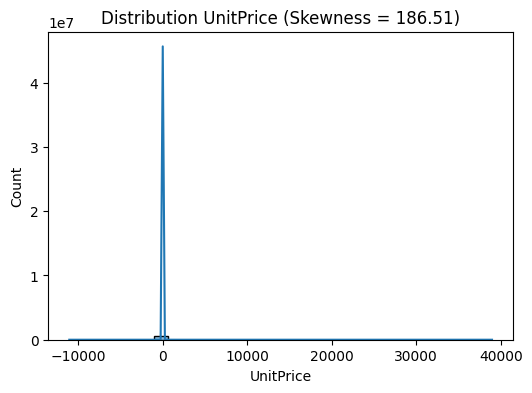

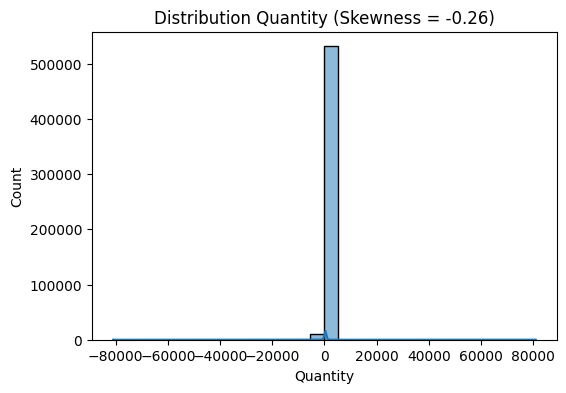

In [54]:
# distribution plot

for col in ['UnitPrice', 'Quantity']:
  plt.figure(figsize = (6,4))
  sns.histplot(df[col], kde = True, bins=30)
  plt.title(f'Distribution {col} (Skewness = {df[col].skew():.2f})')
  plt.show()

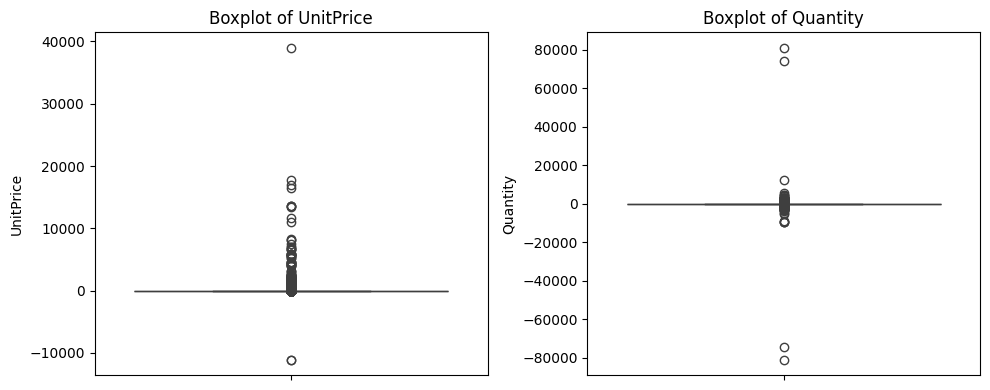

In [55]:
# boxplotting(outliers)

plt.figure(figsize=(10, 4))
for i, col in enumerate(['UnitPrice', 'Quantity']):
    plt.subplot(1, 2, i+1)
    sns.boxplot(y=df[col])
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

In [56]:
# correlations

corr, pval = pearsonr(df['UnitPrice'], df['Quantity'])
print(f"Pearson Correlation: {corr:.2f} (p-value = {pval:.4f})")

Pearson Correlation: -0.00 (p-value = 0.3633)


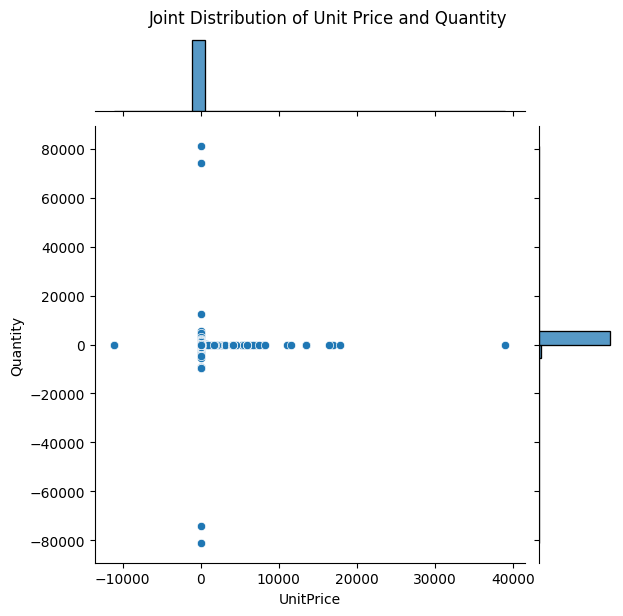

In [57]:
# joint distribution (scatter with marginal)

sns.jointplot(x='UnitPrice', y='Quantity', data=df, kind='scatter', marginal_kws={'bins': 30, 'fill': True})
plt.suptitle('Joint Distribution of Unit Price and Quantity', y=1.02)
plt.show()

In [61]:
# STEP 1: Remove negative Quantity and UnitPrice
df_clean = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)].copy()

# STEP 2: Detect Outliers using IQR
def remove_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return data[(data[column] >= lower) & (data[column] <= upper)]

# Apply to both Quantity and UnitPrice
df_no_outliers = remove_outliers_iqr(df_clean, 'Quantity')
df_no_outliers = remove_outliers_iqr(df_no_outliers, 'UnitPrice')

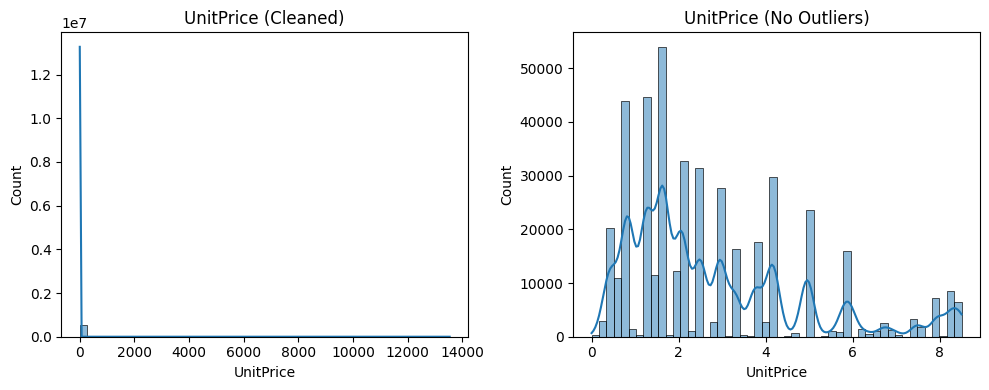

In [62]:
# STEP 3: Replot with better visibility

## Histogram of UnitPrice (before and after removing outliers)
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.histplot(df_clean['UnitPrice'], bins=50, kde=True)
plt.title("UnitPrice (Cleaned)")

plt.subplot(1, 2, 2)
sns.histplot(df_no_outliers['UnitPrice'], bins=50, kde=True)
plt.title("UnitPrice (No Outliers)")
plt.tight_layout()
plt.show()

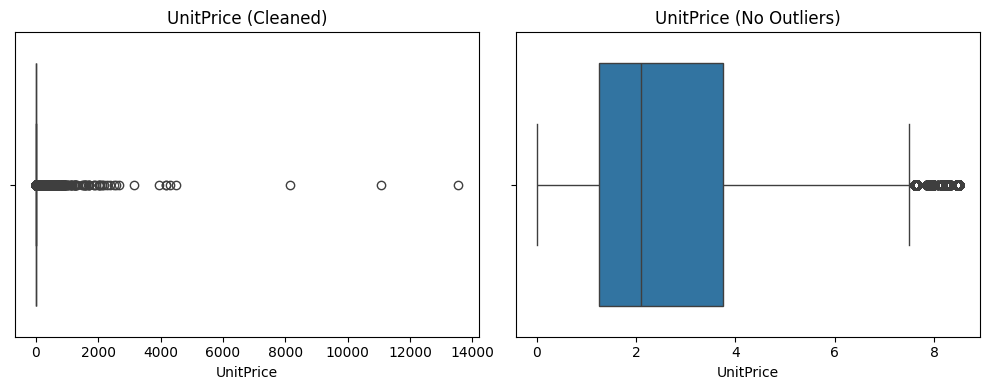

In [63]:
## Boxplots
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.boxplot(x=df_clean['UnitPrice'])
plt.title("UnitPrice (Cleaned)")

plt.subplot(1, 2, 2)
sns.boxplot(x=df_no_outliers['UnitPrice'])
plt.title("UnitPrice (No Outliers)")
plt.tight_layout()
plt.show()

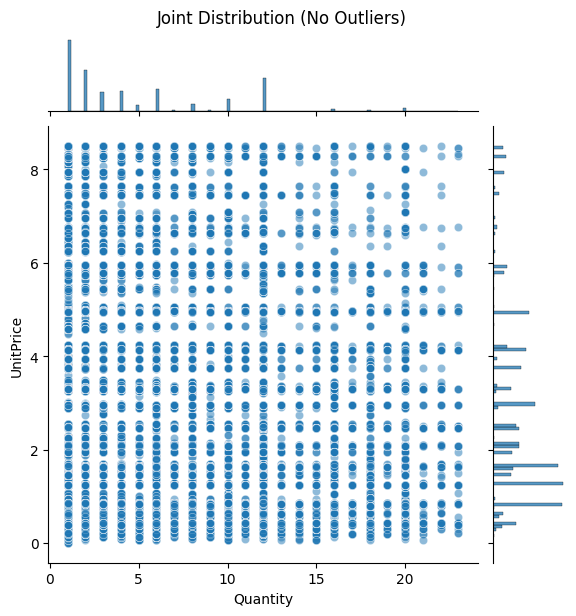

In [64]:
## Jointplot of Quantity vs. UnitPrice (cleaned, no outliers)
sns.jointplot(data=df_no_outliers, x='Quantity', y='UnitPrice', kind='scatter', alpha=0.5)
plt.suptitle("Joint Distribution (No Outliers)", y=1.02)
plt.show()

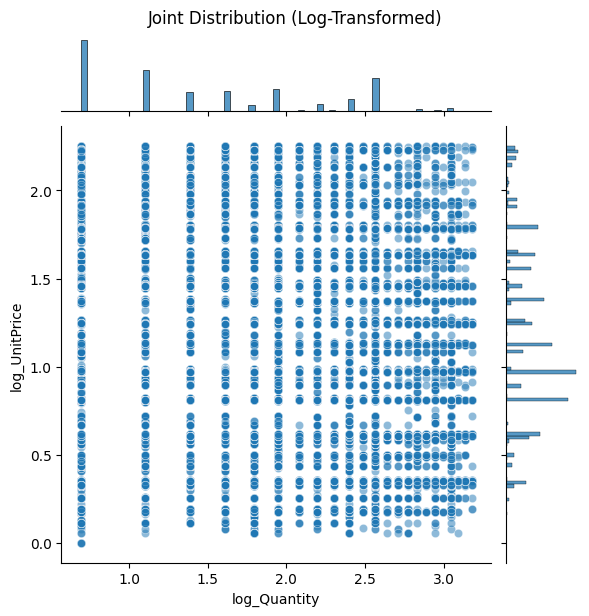

In [65]:
# Add log-transformed columns
df_no_outliers['log_Quantity'] = np.log1p(df_no_outliers['Quantity'])
df_no_outliers['log_UnitPrice'] = np.log1p(df_no_outliers['UnitPrice'])

# Plot joint distribution on log scale
sns.jointplot(
    data=df_no_outliers,
    x='log_Quantity',
    y='log_UnitPrice',
    kind='scatter',
    alpha=0.5
)
plt.suptitle("Joint Distribution (Log-Transformed)", y=1.02)
plt.show()